In [2]:
import dpkt
import os
import struct
import numpy as np
from collections import defaultdict
from pprint import pprint

try:
    from Memoizer import memoize_to_folder
    memoize = memoize_to_folder("e2e_memoization")
except:
    # In case Memoizer isn't present, this decorator will just do nothing
    print("Warning: Unable to import memoizer")
    memoize = lambda x : x


In [3]:
from scapy.all import *

K = 5
H = 1

def blk_cls_idx(fec,):
    blk_cls_idx, = struct.unpack("!H", fec[:2])
    blk = (blk_cls_idx >> 8) & 0b00011111
    cls = ((blk_cls_idx >> 8) & 0b11100000) >> 5
    idx = blk_cls_idx & 0x0F
    
    pkt_len, = struct.unpack("H", fec[4:6])
    return blk, cls, idx, pkt_len

@memoize
def get_latencies(out_dir,
                  encoded_input = False,
                  encoded_output = False,
                  dst_mac_is_ts = True, 
                  compare_counters = True,
                  expected_class = 0):
    
    pcf = os.path.join(out_dir, 'moongen', 'moongen.pcap')
    
    ts_in = []
    ts_out = []    

    f = open(pcf, 'rb')
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    
    last_blk_idx = [None, -1]
    block_buffer = []
    
    n_discarded_buffer = 0
    n_discarded_unknown = 0
    
    def handle_block_buffer(fec, ts, ts_buff):        
        nonlocal n_discarded_unknown, n_discarded_buffer, block_buffer, last_blk_idx
        
        blk, cls, idx, pkt_len = blk_cls_idx(fec)
#         print(blk,cls,idx)
        
        if (cls != expected_class):
            IP(fec).show()
            n_discarded_unknown += 1
            return

        if last_blk_idx[0] is not None and \
                last_blk_idx[0] != blk or \
                last_blk_idx[1] >= idx:
            #print(last_blk_idx, blk, idx, K, block_buffer)
            if len(block_buffer) != K:
                raise Exception("Unfinished block with %d entries" % len(block_buffer))
            ts_buff.extend(block_buffer)
            block_buffer = []
 
        last_blk_idx[0] = blk
        last_blk_idx[1] = idx
        
        if len(block_buffer) >= K:
            n_discarded_buffer += 1
            return

        block_buffer.append(ts)  
        
    skipped = 0
    tss = []
    sort_ts_in = []
    sort_ts_out = []
    #Loop to sort encoded packets based on timestamp. At times the first packet was arriving \
    #out of order, so to prevent that issue, sorting is done.
    for i, (ts, buf) in enumerate(pcap):
        try:
            eth=dpkt.ethernet.Ethernet(buf)
            fec = eth.data

        except Exception as e:
            print("Exception parsing packet {} : {}".format(buf, e))
            Ether(buf).show2()
            raise

        if dst_mac_is_ts:
            x3, x2, x1 = struct.unpack("!HHH", eth.dst)
            ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9
            
        ### Assumes src mac is origin
        x3, x2, x1 = struct.unpack("!HHH", eth.src)
        
        if x1 == 1:                
            if encoded_output:    
                sort_ts_out.append([ts, fec])
            else:
                ts_out.append(ts)
        elif x1 == 2:
            if encoded_input:
                sort_ts_in.append([ts, fec])
            else:
                ts_in.append(ts)
    
    #block of code to sort by first item in the list
    def get_key(item):
        return item[0]
    
    if encoded_input:
        sort_ts_in = sorted(sort_ts_in, key=get_key)
    elif encoded_output:    
        sort_ts_out = sorted(sort_ts_out, key=get_key)
    
    
    if encoded_input:    
        for item in sort_ts_in:
            handle_block_buffer(item[1], item[0], ts_in)
    elif encoded_output:
        for item in sort_ts_out:
            handle_block_buffer(item[1], item[0], ts_out)
        
                
    print("Finished reading pcap: %d total packets \n"
          "Skipped %d packets due to broadcast UDP\n"
          "Discarded %d packets due to buffering \n" 
          "Discarded %d packets due to incorrect FEC class\n"
          "Got %d input and %d output packets"%
          (i, skipped, n_discarded_buffer, n_discarded_unknown, len(ts_in), len(ts_out)))
    
#     if len(block_buffer) != K and len(block_buffer) != 0:
#         raise Exception("Unfinished block at end with %d entries" % len(block_buffer))
        
    if encoded_input:
        ts_in.extend(block_buffer)
    elif encoded_output:
        ts_out.extend(block_buffer)
        
#     ts_in = ts_in[:len(ts_out)]
        
    if len(ts_in) != len(ts_out):
        raise Exception("Received %d input packets and %d output packets" %
                        (len(ts_in), len(ts_out)))
    
    print("Calculated %d latencies" % len(ts_out))
    
    return np.array(ts_in), np.array(ts_out) - np.array(ts_in)

In [14]:

EXP = '/home/ncshy/P4Boosters/testing/fec/execution/test_rerun/cpu_fec_decoder_rerun1/cpu_fec_decoder_rerun1_0.30'


#expected_class = 0 for FPGA; expected_class = 1 for CPU
#For encoded_input, pass encoded_input = True
#For encoded_output, pass encoded_output = True
latencies = get_latencies(EXP, encoded_input=True, expected_class=1)
tot = 0
count = 0
for val in latencies[1]:
    tot += val
    count += 1

#Code to calculate inter packet gap for input packets    
temp = 0
sub_count = 0
sub_tot = 0
for val in latencies[0]:
    if temp == 0:
        temp = val
        continue
    else:
        sub_tot += val - temp
        temp = val
    sub_count += 1    
    
sub_avg = sub_tot/sub_count    
avg = tot/count   
print((avg, tot, count))
print((sub_avg, sub_tot, sub_count))
print("Calculated avg latency %f" %(avg))

Reading /home/ncshy/P4Boosters/testing/fec/execution/test_rerun/cpu_fec_decoder_rerun1/cpu_fec_decoder_rerun1_0.30/moongen/moongen.pcap
Finished reading pcap: 21999 total packets 
Skipped 0 packets due to broadcast UDP
Discarded 2000 packets due to buffering 
Discarded 0 packets due to incorrect FEC class
Got 9995 input and 10000 output packets
Calculated 10000 latencies
(4.0915685999999594e-05, 0.40915685999999596, 10000)
(0.00034173058185818587, 3.4169640880000003, 9999)
Calculated avg latency 0.000041


In [5]:
#Cell that calculates average of multiple line rates

#linerate = [0.10, 0.25, 0.30]
linerate = [0.30]
for rate in linerate:
    tot_itput = 0
    tot_otput = 0
    tot_latency = 0
    all_latency = []
    i = 1
    
    while i <= 5:
        EXP = "/home/ncshy/P4Boosters/testing/fec/execution/test_multiple_run/cpu_fec_encoder_%d/cpu_fec_encoder_%d_%.2f"%(i,i,rate)
        #expected_class = 0 for FPGA; expected_class = 1 for CPU
        #For encoded_input, pass encoded_input = True
        #For encoded_output, pass encoded_output = True
        latencies = get_latencies(EXP, encoded_output=True, expected_class=1)
        tot = 0
        count = 0
        for val in latencies[1]:
            tot += val
            count += 1
        avg = tot/count
        all_latency.append(avg)
        #if i == 4:
         #   i += 2
          #  continue
        i += 1
        
    count = 0
    print(all_latency)
    for item in all_latency:
        tot_latency += item
        count += 1
    avg_latency = tot_latency/count
    print("latency for fpga_compress_rerun_%.2f"%(rate))
    print(avg_latency)
    deviation_latency = get_std_deviation(all_latency, avg_latency)
    print("std_deviation of latency is: " + str(deviation_latency))

Reading /home/ncshy/P4Boosters/testing/fec/execution/test_multiple_run/cpu_fec_encoder_1/cpu_fec_encoder_1_0.30/moongen/moongen.pcap
Finished reading pcap: 21999 total packets 
Skipped 0 packets due to broadcast UDP
Discarded 2000 packets due to buffering 
Discarded 0 packets due to incorrect FEC class
Got 10000 input and 9995 output packets
Calculated 10000 latencies
Reading /home/ncshy/P4Boosters/testing/fec/execution/test_multiple_run/cpu_fec_encoder_2/cpu_fec_encoder_2_0.30/moongen/moongen.pcap
Finished reading pcap: 21999 total packets 
Skipped 0 packets due to broadcast UDP
Discarded 2000 packets due to buffering 
Discarded 0 packets due to incorrect FEC class
Got 10000 input and 9995 output packets
Calculated 10000 latencies
Reading /home/ncshy/P4Boosters/testing/fec/execution/test_multiple_run/cpu_fec_encoder_3/cpu_fec_encoder_3_0.30/moongen/moongen.pcap
Finished reading pcap: 21999 total packets 
Skipped 0 packets due to broadcast UDP
Discarded 2000 packets due to buffering 
D

In [4]:
def get_std_deviation(all_values, avg_value):
    tot_variation = 0
    variance = []
    for val in all_values:
        variation = ((val - avg_value) ** 2) / (len(all_values) - 1)
        variance.append(variation)
        tot_variation += variation
        
    return tot_variation ** (1/2)    

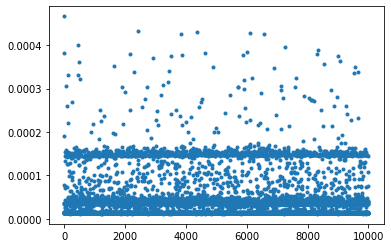

In [23]:
plt.figure()
plt.plot(latencies[1] , '.')

In [5]:
pcf = os.path.join(EXP, 'moongen', 'moongen.pcap')
pcap=dpkt.pcap.Reader(open(pcf, 'rb'))

In [7]:
for i, (ts, pkt) in enumerate(pcap):
    print(pkt)
    if i > 10:
        break

b'\x00\x04`P\xdb\xea\x00\x00\x00\x00\x00\x02\x124\x00\x00\x08\x00\x04\x10E\x00\x01\x11\x08\x04\x00\x00\x11=\x93\x9c\x01\x01\x01\x01\x01\x01\x01\x01\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11\x11'
b'\x00\x04`R\x07\xe5\x00\x00\x00\x00\x00\x02\x124\x00\x01\x08\x00\x04\x10E\x00\x01\x11\x1c\x17\x00\x00"=m\x87\x02\x02\x02\x02\x02\x02\x02\x02"""""""""""""""""""""""""""""""""""""""""""""""""""'
b'\x00\x04`SUI\x00\x00\x00\x00\x00\x02\x124\x00\x02\x08\x00\x04\x10E\x00\x01\x110*\x00\x003=Gr\x03\x03\x03\x03\x03\x03\x03\x03333333333333333333333333333333333333333333333333333'
b'\x00\x04`T\xa2W\x00\x00\x00\x00\x00\x02\x124\x00\x03\x08\x00\x04\x10E\x00\x01\x11\xb4=\x00\x00D=\xb1\\\x04\x04\x04\x04\x04\x04\x04\x04DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD'
b'\x00\x04`U\xef\x8d\x00\x00\x00\x00\x00\x02\x124\x00\x04\x08\x00\x04\x10E\x00\x01\x1

<IPython.core.display.Javascript object>


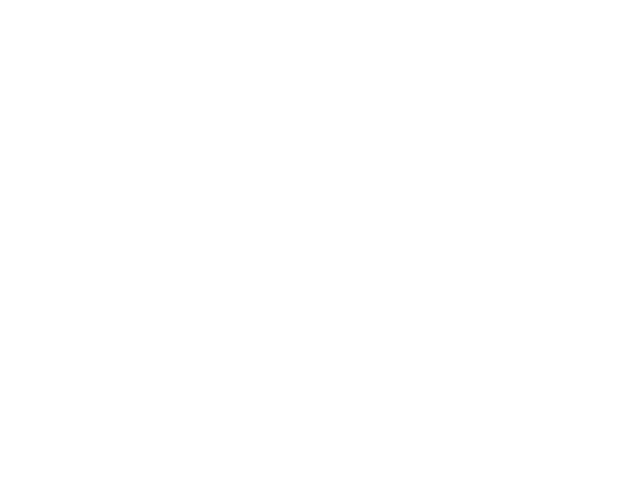

TypeError: can't multiply sequence by non-int of type 'float'

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
x = plt.hist(latencies * 1e6, 100)
plt.xlabel("Latencies (µS)")
plt.ylabel("N Pkts")
plt.yscale('log')

<IPython.core.display.Javascript object>


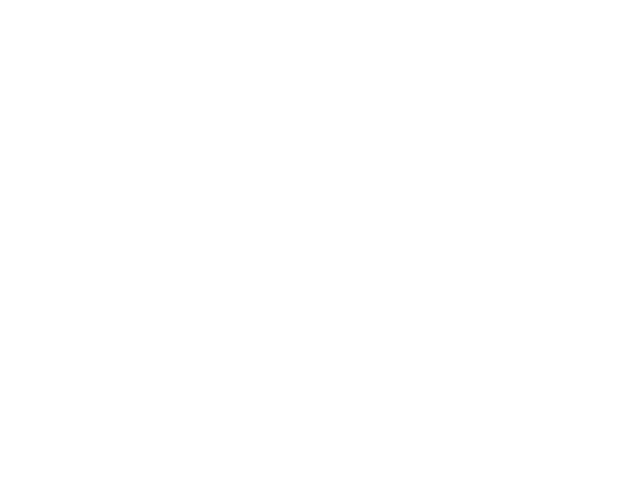

TypeError: can't multiply sequence by non-int of type 'float'

In [15]:
plt.figure()
plt.plot(latencies * 1e6,'.')